In [1]:
import yaml
import numpy as np
import zarr
import os
import fibsem_tools as fst
import fly_organelles
import xarray as xr
from xarray_multiscale import multiscale, windowed_mode
#from fibsem_tools.io.multiscale import multiscale_group
from numcodecs import GZip
from cellmap_schemas.annotation import AnnotationGroup, AnnotationGroupAttrs, wrap_attributes, CropGroupAttrs, SemanticSegmentation, AnnotationArrayAttrs
from pydantic_zarr import ArraySpec, GroupSpec

In [2]:
fst.io.multiscale.multiscale_group

AttributeError: module 'fibsem_tools.io' has no attribute 'multiscale'

In [2]:
UNKNOWN = 255
PRESENT = 1
ABSENT = 0

In [3]:
classes = fly_organelles.label_preparation.read_label_yaml("/home/heinrichl@hhmi.org/code/fly-organelles/label.yaml")
crop_path = "/nrs/saalfeld/heinrichl/data/cellmap_labels/fly_organelles/culture/jrc_cos7-1a/groundtruth.zarr/crop237"
crop = fly_organelles.label_preparation.Crop(classes, crop_path)
new_class = classes["organelle"]
arr = crop.add_new_class(new_class)

In [ ]:
# atts = crop.crop_root.attrs
# atts["cellmap"]["annotation"]["class_names"] = atts["cellmap"]["annotation"]["class_names"] + ["organelle"]
# crop.crop_root.attrs.update(atts)

In [ ]:
#ms_group = crop.crop_root.create_group("organelle")

In [4]:
xrarr = xr.DataArray(arr, coords=crop.get_coords())

/groups/saalfeld/home/heinrichl/Brew/mambaforge/envs/fly-organelles_dev_3.10/lib/python3.10/site-packages/pydantic_ome_ngff/v04/multiscales.py:104: UserWarning: The name field was set to `None`. Version 0.4 of the OME-NGFF spec
states that the `name` field of a Multiscales object should not be
None.
  warnings.warn(textwrap.fill(msg))


In [5]:
multi = {m.name: m for m in multiscale(xrarr, windowed_mode, (2,2,2), chunks=crop.get_chunking())}

In [6]:
hist = dict()
for mslvl, msarr in multi.items():
    ids, counts = np.unique(msarr, return_counts=True)
    hist[mslvl] = dict()
    if UNKNOWN in ids:
        hist[mslvl]["unknown"] = counts[list(ids).index(UNKNOWN)]
    if ABSENT in ids:
        hist[mslvl]["absent"] = counts[list(ids).index(ABSENT)]

In [7]:
annotation_array_attrs = dict()
for mslvl in multi.keys():
    annotation_array_attrs[mslvl] = AnnotationArrayAttrs(class_name="organelle", complement_counts=hist[mslvl], annotation_type=SemanticSegmentation(encoding={"absent": ABSENT, "present": PRESENT, "unknown": UNKNOWN}))

In [8]:
label_array_specs = dict()
for mslvl, msarr in multi.items():
    label_array_specs[mslvl] = ArraySpec.from_array(
        msarr,
        chunks=crop.get_chunking(),
        compressor = GZip(-1),
        attrs = wrap_attributes(annotation_array_attrs[mslvl]).dict(),
    )

In [9]:
annotation_group_attrs = AnnotationGroupAttrs(class_name="organelle", description="", annotation_type=SemanticSegmentation(encoding={"absent": ABSENT, "present": PRESENT, "unknown": UNKNOWN}))
ms_group = multiscale_group(list(multi.values()), metadata_types=("ome-ngff@0.4",), array_paths = list(multi.keys()), chunks=crop.get_chunking(), compressor=GZip(-1))
group_spec = GroupSpec(attrs=wrap_attributes(annotation_group_attrs).dict() | ms_group.attrs, members=label_array_specs)

In [10]:
store = zarr.NestedDirectoryStore(crop.crop_path)

In [11]:
group_spec.to_zarr(store, path="organelle", overwrite=True)

<zarr.hierarchy.Group '/organelle'>

In [13]:
for mslvl, msarr in multi.items():
    mszarr = zarr.Array(
        store,
        path=f"organelle/{mslvl}",
        write_empty_chunks=False
    )
    mszarr[:] = msarr.to_numpy()
    

In [27]:
crop.crop_root.create_dataset(name="organelle", data=arr, dtype=np.uint8, chunks=(256,256,256), dimension_separator="/", overwrite=True, fill_value=0)

<zarr.core.Array '/crop237/organelle' (385, 400, 400) uint8>

In [13]:
"organelle" in crop.get_annotated_classes()

True

In [18]:
type(crop.crop_root)

zarr.hierarchy.Group

In [14]:
crop.crop_root.attrs["cellmap"]["annotation"]["class_names"]

['ves_lum',
 'lyso_mem',
 'hchrom',
 'mito_lum',
 'perox',
 'golgi_lum',
 'np',
 'mt_in',
 'er',
 'nucleo',
 'mito_mem',
 'echrom',
 'bm',
 'er_mem_all',
 'eres_mem',
 'ne_mem',
 'glyco',
 'perox_mem',
 'isg_lum',
 'ne_mem_all',
 'golgi',
 'pm',
 'ld_lum',
 'er_lum',
 'er_mem',
 'nucpl',
 'mt',
 'cent_all',
 'ne',
 'np_out',
 'np_in',
 'ves',
 'endo_mem',
 'cent_sdapp',
 'perox_lum',
 'rbc',
 'cyto',
 'nuc',
 'endo',
 'nhchrom',
 'isg_ins',
 'nechrom',
 'isg',
 'ld',
 'lyso',
 'mito',
 'ves_mem',
 'ld_mem',
 'lyso_lum',
 'cent',
 'mt_out',
 'tbar',
 'eres_lum',
 'endo_lum',
 'cent_dapp',
 'golgi_mem',
 'mito_ribo',
 'ne_lum',
 'chrom',
 'eres',
 'ecs',
 'organelle']

In [17]:
fst.read(crop_path).attrs["cellmap"]["annotation"]["class_names"]

['ecs',
 'pm',
 'mito_mem',
 'mito_lum',
 'mito_ribo',
 'golgi_mem',
 'golgi_lum',
 'ves_mem',
 'ves_lum',
 'endo_mem',
 'endo_lum',
 'lyso_mem',
 'lyso_lum',
 'ld_mem',
 'ld_lum',
 'er_mem',
 'er_lum',
 'eres_mem',
 'eres_lum',
 'ne_mem',
 'ne_lum',
 'np_out',
 'np_in',
 'hchrom',
 'nhchrom',
 'echrom',
 'nechrom',
 'nucpl',
 'nucleo',
 'mt_out',
 'cent',
 'cent_dapp',
 'cent_sdapp',
 'cyto',
 'mt_in',
 'nuc',
 'glyco',
 'golgi',
 'ves',
 'endo',
 'lyso',
 'ld',
 'rbc',
 'eres',
 'perox_mem',
 'perox_lum',
 'perox',
 'mito',
 'er',
 'ne',
 'np',
 'chrom',
 'mt',
 'isg_lum',
 'isg_ins',
 'isg',
 'tbar',
 'bm',
 'cent_all',
 'er_mem_all',
 'ne_mem_all']

In [4]:
import matplotlib.pyplot as plt

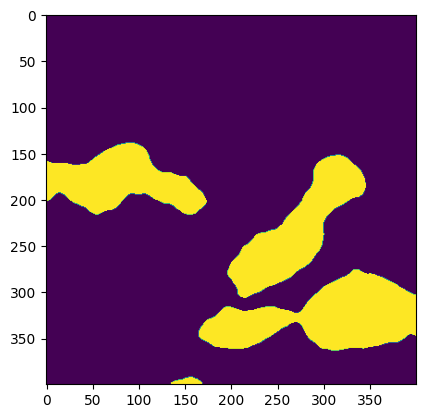

In [5]:
plt.imshow(arr[100]==1)

In [19]:
crop.get_array("mito_lum")

KeyError: 'mito_lum'

In [ ]:
yaml.safe_load()

In [2]:
root_gt_path = "/nrs/saalfeld/heinrichl/data/cellmap_labels/fly_organelles/"

In [3]:
with open("../label.yaml") as f:
    label = yaml.safe_load(f)

In [13]:
cr =fst.access("/nrs/saalfeld/heinrichl/data/cellmap_labels/fly_organelles/culture/jrc_cos7-1a/groundtruth.zarr/crop237", mode="r+")

In [18]:
annotated_classes = set(cr.attrs["cellmap"]["annotation"]["class_names"])

In [20]:
some_label = next(iter(annotated_classes))
cr[some_label]["s0"].shape

(385, 400, 400)

In [10]:
type(label["nuc"])

set

In [18]:
with open("../data.yaml") as f:
    data = yaml.safe_load(f)


In [5]:
for lbl, sublbls in label.items():
    print(lbl, sublbls)

nuc ['ne_mem', 'ne_lum', 'np_out', 'np_in', 'hchrom', 'nhchrom', 'echrom', 'nechrom', 'nucpl', 'nucleo']
golgi ['golgi_mem', 'golgi_lum']
ves ['ves_mem', 'ves_lum']
endo ['endo_mem', 'endo_lum']
lyso ['lyso_mem', 'lyso_lum']
ld ['ld_mem', 'ld_lum']
eres ['eres_mem', 'eres_lum']
perox ['perox_mem', 'perox_lum']
mito ['mito_mem', 'mito_lum', 'mito_ribo']
ne ['ne_mem', 'ne_lum', 'np_out', 'np_in']
np ['np_out', 'np_in']
chrom ['hchrom', 'nhchrom', 'echrom', 'nechrom']
mt ['mt_out', 'mt_in']
isg ['isg_mem', 'isg_lum', 'isg_ins']
er_mem_all ['er_mem', 'eres_mem', 'ne_mem']
ne_mem_all ['ne_mem', 'np_out', 'np_in']
cent_all ['cent', 'cent_dapp', 'cent_sdapp']
chloroplast ['chloroplast_lum', 'chloroplast_mem', 'chloroplast_sg']
vacuole ['vacuole_lum', 'vacuole_mem']
er ['er_mem', 'er_lum', 'eres_mem', 'eres_lum', 'ne_mem', 'ne_lum', 'np_out', 'np_in', 'er_mem_all', 'ne_mem_all']
cell ['pm', 'mito_mem', 'mito_lum', 'mito_ribo', 'golgi_mem', 'golgi_lum', 'ves_mem', 'ves_lum', 'endo_mem', 'endo_l

In [23]:
for ds_dir, ds_info in data.items():
    crops = []
    for crop in ds_info["crops"]:
        crops.extend(crop.split(","))
    for crop in crops:
        path = os.path.join(root_gt_path, ds_dir, "groundtruth.zarr", crop)
        crop_zarr = zarr.open(path, "r")
        annotated = crop_zarr.attrs["cellmap"]["annotation"]["class_names"]
        cans = []
        cants = []
        for lbl, sublbls in label.items():
            if all(sublbl in annotated for sublbl in sublbls):
                cans.append(lbl)
                annotated.append(lbl)
            else:
                cants.append(lbl)
        print(f"{crop}, cans: {cans}, cants: {cants}")
        #for lbl, sublbs in label.items():
            


crop234, cans: ['nuc', 'golgi', 'endo', 'lyso', 'ld', 'eres', 'perox', 'ne', 'np', 'chrom', 'mt', 'er_mem_all', 'ne_mem_all', 'cent_all', 'er'], cants: ['ves', 'mito', 'isg', 'chloroplast', 'vacuole', 'cell']
crop236, cans: ['nuc', 'golgi', 'endo', 'lyso', 'ld', 'eres', 'perox', 'ne', 'np', 'chrom', 'mt', 'er_mem_all', 'ne_mem_all', 'cent_all', 'er'], cants: ['ves', 'mito', 'isg', 'chloroplast', 'vacuole', 'cell']
crop237, cans: ['nuc', 'golgi', 'endo', 'lyso', 'ld', 'eres', 'perox', 'ne', 'np', 'chrom', 'mt', 'er_mem_all', 'ne_mem_all', 'cent_all', 'er'], cants: ['ves', 'mito', 'isg', 'chloroplast', 'vacuole', 'cell']
crop239, cans: ['nuc', 'golgi', 'endo', 'lyso', 'ld', 'eres', 'perox', 'ne', 'np', 'chrom', 'mt', 'er_mem_all', 'ne_mem_all', 'cent_all', 'er'], cants: ['ves', 'mito', 'isg', 'chloroplast', 'vacuole', 'cell']
crop248, cans: ['nuc', 'golgi', 'endo', 'lyso', 'ld', 'eres', 'perox', 'ne', 'np', 'chrom', 'mt', 'er_mem_all', 'ne_mem_all', 'cent_all', 'er'], cants: ['ves', 'mit